In [1]:
### Dynamical Friction in a stable Plummer's Sphere - Initial Conditions code for 'treecode' ### 

In [2]:
###################################################################################################################

In [3]:
## Section 1 ##

# Creation of the initial condition file without the perturber 
# A stable Plummer's sphere is initialized and the particles' positions and velocities are 
# saved in a file.txt that can be used to verify, using the Barners' tree code and the notebook 
# devoted to the Plummer stability, if the generated system is really at equilibirum 

In [4]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
## Definition of the parameters of the system (in internal units)
Nparticles = 30000
Ndimensions = 3
time = 0   # initial time simulation
r_scale = 10 # scale radius of the Plummer's sphere 
M = 1 # total mass of the system
m = M/Nparticles # mass of each particle (equal mass particles)

## distribution function (not normalized)
def dist_func(q):
    return (1-q**2)**(7/2)*q**2

q_max = (2)**(1/2)/3  # abscissa where the distribution 'dist_func' has a maximum
f_max = dist_func(q_max) 

## Positions setting function
def positions(b):  
    # position of the particle in spherical coordinates
    k = np.random.random() # generation of a random number uniformly distributed in [0,1) 
    R = b*k**(1/3)/(1-k**(2/3))**(1/2)
    k = np.random.random()
    t = math.acos(1-(2*k))
    k = np.random.random()
    f = 2*(math.pi)*k 
    # position of the particle in cartesian coordinates
    x = R*(math.sin(t))*(math.cos(f))
    y = R*(math.sin(t))*(math.sin(f))
    z = R*(math.cos(t))
    return x,y,z,R,t,f

## Velocity setting function
def velocities(a,b):      
    rel_pot = M/(a**2+b**2)**(1/2) # relative potential of the particle
    v_max = (2*rel_pot)**(1/2)
    leave = 'False' # used to exit the 'while' cycle
    while leave=='False':
        q = np.random.random() 
        q1 = np.random.random()*f_max   
        if q1<=dist_func(q):
            vmod = q*v_max # modulo of the velocity
            # spherical distribution in the velocities: theta and phi distributed in such a way
            k = np.random.random()
            t = math.acos(1-(2*k))
            k = np.random.random()
            f = 2*(math.pi)*k 
            # velocity of the particle in cartesian coordinates
            vx = vmod*(math.sin(t))*(math.cos(f))
            vy = vmod*(math.sin(t))*(math.sin(f))
            vz = vmod*(math.cos(t))
            leave = 'True'
    return vx,vy,vz,q

## Creation and filling of the position and velocity arrays
x = np.empty(Nparticles)
y = np.empty(Nparticles)
z = np.empty(Nparticles)
vx = np.empty(Nparticles)
vy = np.empty(Nparticles)
vz = np.empty(Nparticles)

## Radius, theta, phi and q arrays are used in the next section to check the initial conditions 
radius = np.empty(Nparticles)  
theta = np.empty(Nparticles)
phi = np.empty(Nparticles)
q = np.empty(Nparticles) 

for i in range(Nparticles):
    x[i],y[i],z[i],radius[i],theta[i],phi[i] = positions(r_scale)
    vx[i],vy[i],vz[i],q[i] = velocities(radius[i],r_scale)

In [6]:
## Saving the initial conditions in 'initial_conditions_file.txt' that then will be 
## runned by the c++ code
with open('initial_conditions_file.txt','w') as file:
    file.write("{}\n{}\n{}\n".format(Nparticles,Ndimensions,time))
    for i in range(Nparticles):
        file.write("{}\n".format(m))
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(x[i],y[i],z[i]))
    for i in range(Nparticles):
        file.write("{:25.15e}{:25.15e}{:25.15e}\n".format(vx[i],vy[i],vz[i]))  
## Saving some system's parameters used during the analysis section
with open('system_properties.txt','w') as file:
    file.write("{}\n{}\n{}\n".format(Nparticles,M,r_scale))

In [7]:
###################################################################################################################

In [8]:
## Section 2 ##

# Check of the Initial Conditions 

In [9]:
# Before evolving the system, it's recommended to check the initial conditions: this can be done 
# directly in the  notebook devoted to the study of the Plummer stability (choosing the variable 
# 'snapshot_to_check = 0'); however, for computational costs, we recommend to do it here (indeed 
# here we have already the R, theta, phi and q arrays; in the analysis code they have to be recomputed)

In [10]:
from scipy.stats import chisquare

In [11]:
## Radius Distribution

In [12]:
## pdf and cdf of the radial positions 
def pdf_r(r,b):
    return (3/b**3)*(r**2)*(1+(r/b)**2)**(-5/2) 
def cdf_r(b,r):
    return b**(-3)*r**3/(1+(r/b)**2)**(3/2)

In [13]:
# Chisquare Section #
empirical,edges = np.histogram(radius,bins='auto')
counts = np.copy(empirical) # used in the histogram section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_r(r_scale,edges[i_bin+1]) - cdf_r(r_scale,edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.09148713717263036, test superato


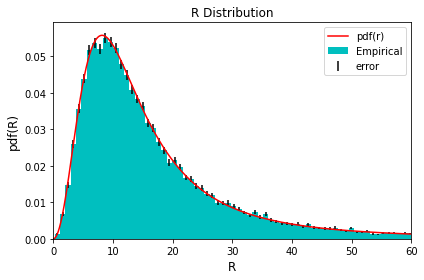

In [14]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_r, bin_edges_r, hist_r = plt.hist(radius,bins='auto',range=None,density=True,
                                                    color='c',label='Empirical')

error = np.divide(error, area) # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_r,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
left_range = 0
right_range = r_scale*6
radius_pdf = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)     
radius_pdf = pdf_r(ascissa,r_scale) 

plt.plot(ascissa,radius_pdf,color='r',label='pdf(r)')
plt.xlim(left_range,right_range)

plt.title('R Distribution') 
plt.xlabel('R',fontsize=12)
plt.ylabel('pdf(R)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('R_histo_(t=0_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(Nparticles,M,r_scale,pvalue)) 
# N.B. if you change the scale radius or if you want to see the whole histogram, you need to do a manual rescale

In [15]:
## Phi Distribution

In [16]:
## pdf and cdf of the phi angle
def pdf_p():
    return (2*math.pi)**(-1)
def cdf_p(p):
    return p*(2*math.pi)**(-1)

In [17]:
# Chisquare Section #
empirical,edges = np.histogram(phi,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_p(edges[i_bin+1]) - cdf_p(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.22424478378585275, test superato


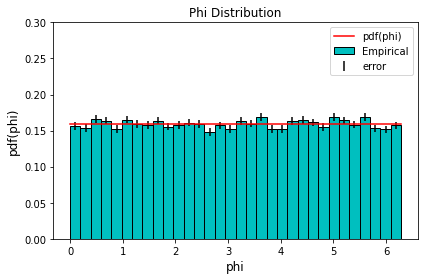

In [18]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_p, Bin_edges_p, hist_p = plt.hist(phi,bins='auto',range=None,
                                                    density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_p,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
phi_pdf = np.empty(10)
ascissa = np.linspace(0,2*math.pi,10)
phi_pdf = np.ones(10)*pdf_p()        
        
plt.plot(ascissa,phi_pdf,color='r',label='pdf(phi)')
plt.ylim(0,0.3)

plt.title('Phi Distribution') 
plt.xlabel('phi',fontsize=12)
plt.ylabel('pdf(phi)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('Phi_histo_(t=0_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(Nparticles,M,r_scale,pvalue)) 

In [19]:
## Theta Distribution

In [20]:
## pdf and cdf of the phi angle
def pdf_t(t):
    return 0.5*np.sin(t)
def cdf_t(t):
    return 0.5*(1-np.cos(t))

In [21]:
# Chisquare Section #
empirical,edges = np.histogram(theta,bins='auto')
counts = np.copy(empirical) # used in the Histogram Section
theorical = []
for i_bin in range(len(empirical)):
    if empirical[i_bin]>9:
        prob = cdf_t(edges[i_bin+1]) - cdf_t(edges[i_bin])
        theorical.append(prob*Nparticles)        
empirical = empirical[empirical>9] 

sta, pvalue = chisquare(empirical,theorical)
if pvalue>=0.05: print('pvalue: {}, test superato'.format(pvalue))
else: print('pvalue: {}, test non superato'.format(pvalue))

pvalue: 0.7487495881079602, test superato


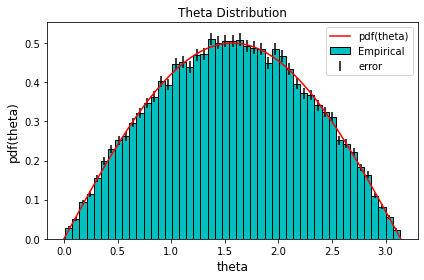

In [22]:
# Histogram Section #

# Generation of the normalized histogram and of the error bars
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_t, Bin_edges_t, hist_t = plt.hist(theta,bins='auto',range=None,
                                                    density=True,color='c',edgecolor='black',label='Empirical')
error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_t,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
theta_pdf = np.empty(1000)
ascissa = np.linspace(0,math.pi,1000)
theta_pdf = pdf_t(ascissa)        
    
plt.plot(ascissa,theta_pdf,color='r',label='pdf(theta)')

plt.title('Theta Distribution') 
plt.xlabel('theta',fontsize=12)
plt.ylabel('pdf(theta)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('Theta_histo_(t=0_Np={}_M={}_Rscal={})_(pval={:3.3}).jpg'.format(Nparticles,M,r_scale,pvalue)) 

In [23]:
## Density Distribution

In [24]:
# density function
def rho(r,b,M):
    return M/(4/3*math.pi*b**3)/(1+(r/b)**2)**(5/2)

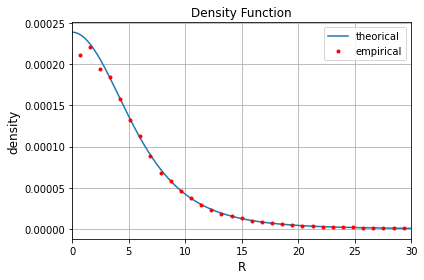

In [25]:
## generation of the theorical density
left_range = 0
right_range = r_scale*3
density = np.empty(1000)
ascissa = np.linspace(left_range,right_range,1000)
density = rho(ascissa,r_scale,M)  
plt.plot(ascissa,density,label='theorical')

## computation of the empirical density
counts, bin_edges = np.histogram(radius, bins='auto') # if you are not satisfied, choose 'bins' manually
system_density = []
for i in range(len(counts)):
    system_density.append(counts[i]*m/(4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3)))
center = bin_edges[1::]-(bin_edges[1::]-bin_edges[:-1])/2
plt.plot(center,system_density,'r.',label='empirical')

plt.xlim(left_range,right_range)

plt.title('Density Function')
plt.xlabel('R',fontsize=12)
plt.ylabel('density',fontsize=12)

plt.legend()
plt.grid()
plt.tight_layout()
#plt.savefig('density_function_(t=0_Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale)) 
## N.B. in order to compute the error associated to the empirical density, one should use the 
## error propagation
## In this case we decided to evaluate the accuracy qualitatively

In [26]:
## q Distribution

In [27]:
Norm = 23.285605868167888 # normalization constant of the distribution function computed 
                          # numerically (you can find the code at the end of this notebook)
def pdf_q(q,Norm): 
    return Norm*(1-q**2)**(7/2)*q**2
q_max = (2)**(1/2)/3  # abscissa where the distribution 'dist_func' has a maximum
f_max = pdf_q(q_max,Norm)

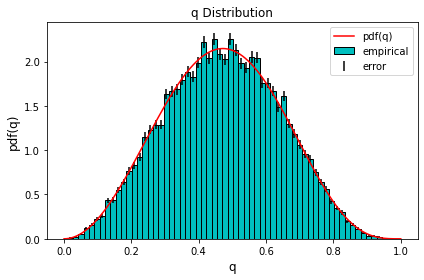

In [28]:
# Histogram Section #

counts, edges = np.histogram(q,bins='auto')
area = sum(np.diff(edges)*counts)
error = np.sqrt(counts) # Poissonian errors
bincenters = 0.5*(edges[1:]+edges[:-1])

normalized_counts_q, Bin_edges_q, hist_q = plt.hist(q,bins='auto',range=None,
                                                    density=True,color='c',edgecolor='black',label='empirical')

error = error/area # the error bar must be rescaled since we normalized the histogram 
plt.errorbar(bincenters,normalized_counts_q,yerr=error,fmt='none',label='error',color='k')

## generation of the arrays containing some pdf's points
q_pdf = np.empty(1000)
ascissa = np.linspace(0,1,1000)
q_pdf = pdf_q(ascissa,Norm)        
        
plt.plot(ascissa,q_pdf,color='r',label='pdf(q)')

plt.title('q Distribution')
plt.xlabel('q',fontsize=12)
plt.ylabel('pdf(q)',fontsize=12)

plt.legend()
plt.tight_layout()
#plt.savefig('q_histo_(t=0_Np={}_M={}_Rscal={}).jpg'.format(Nparticles,M,r_scale,pvalue)) 

In [29]:
###################################################################################################################

In [30]:
## Section 3 ##

# Instruction to compile the 'treecode' from the terminal and hints to set the parameters ##

In [31]:
# When you have runned 'Section 1', your system initial conditions will be saved in 
# 'initial_conditions_file.txt'; then, before running the 'notebook for the Plummer's Sphere Stability, 
#  you need to run from the terminal the c++ executable file. You can write (for example):
#
#  ./treecode in=initial_conditions_file.txt out=%d.data dtime=0.05 eps=0.1 theta=0.1 options=out-phi 
#                                                                tstop=300 dtout=10 > system_description.txt
#
# All the parameters are expressed in internal units; it's useful to compute the dynamical time of the system:

t_dynamical = r_scale/(M/r_scale)**(1/2)

# Here you can find the description of some of the parameters passed through the terminal 
# (see for more details the documentation of the 'Barnes tree code' - http://www.ifa.hawaii.edu/
#                                                                faculty/barnes/treecode/treeguide.html):
# 
# - dtime: it is the integration time step; for example choose: dtime=t_dynamical/(10^a); 
#   if you decrease eps, you should also decrease dtime
#   To be correct, 't_dynamical' isn't computed in the correct way; however, it's of the same order 
#   of the real one.

dtime = t_dynamical/(10**2)

# - eps: it is the smoothing length used in the gravitational force calculation.
#  Choose a value that is a fraction of the typical separation between particles: 
#                                                                      10^(-b)*(Vol/Nparticles)**(1/3)
#  Here we divided the sphere in shells, computed the particles' mean distance in each shell 
#  and selected the smallest one

counts, bin_edges = np.histogram(radius, bins='auto')
MeanSeparation = []
for i in range(len(counts)):
    if counts[i]!=0:
        MeanSeparation.append( ((4/3*math.pi*(bin_edges[i+1]**3-bin_edges[i]**3))/counts[i])**(1/3))
MinMeanSeparation = min(MeanSeparation)
eps = MinMeanSeparation/5

# - theta: it is the opening angle used to adjust the accuracy of the force calculation. 
#   The less is theta the more accurate is the results, albeit at greater computational expense.

theta = 0.5

# - options=out-phi: it saves in the output_data.txt also the potential energy

# - tstop: it is the time at which the N-Body integration terminates. Set it, for example, 
#          as tstop=10*t_dynamical

tstop = 10*t_dynamical

# - dtout: it is the time interval between output files. To insure that outputs are performed 
#   when expected, dtout should be a multiple of dtime. The number of snapshots depends on 'dtout': 
#   the less its value is, the more number of outputs you'll have. A greater number of snapshots 
#   will be useful during the analysis because you'll have more information about the system but
#   the computational cost of the analysis will be increased.

dtout = dtime*10

Nsnapshots = int(tstop/dtout)

In [32]:
print('\ndtime: ',dtime)
print('\nMean separation: ',MinMeanSeparation,'    eps: ',eps)
print('\ntheta: ', theta)
print('\ntstop: ', tstop)
print('\ndtout: ', dtout)
print('\nNsnaphots: ', Nsnapshots)


dtime:  0.31622776601683794

Mean separation:  0.5328963549948176     eps:  0.10657927099896351

theta:  0.5

tstop:  316.2277660168379

dtout:  3.1622776601683795

Nsnaphots:  99


In [33]:
###################################################################################################################

In [34]:
## Section 4 ##

# Section used to include the perturber in the previously generated system. This Section can be run
# independently from the previous ones; you need to include in the same directory the .txt files 
# generated in Section 1


In [35]:
import math
import numpy as np

In [36]:
def plummer_pot(M,r,a):
    return -M/(r**2+a**2)**(1/2)

In [37]:
## Number of particles, total mass and scale radius of the already generated Plummer's sphere 
Nparticles,M,r_scale = np.loadtxt('system_properties.txt') 
Nparticles = int(Nparticles)

## Setting of the perturber's properties 
M_pert = 0.01
r_apocenter = 6 
r_pericenter = 2 

# potential and velocities at the apo- and peri- center (obtained assuming conservation of the 
# energy and of the angular momentum)
pot_apocenter = plummer_pot(M,r_apocenter,r_scale)
pot_pericenter = plummer_pot(M,r_pericenter,r_scale)
v_apocenter = np.sqrt( 2*(pot_apocenter-pot_pericenter) /((r_apocenter/r_pericenter)**2-1) )
v_pericenter = np.sqrt( 2*(pot_pericenter-pot_apocenter) /((r_pericenter/r_apocenter)**2-1) )

# position and velocity of the perturber
pos_pert = [0,r_apocenter,0]
v_pert = [v_apocenter,0,0]

In [38]:
with open('initial_conditions_file.txt','r') as file:
    data = file.readlines()

Nbodies = Nparticles+1
data[0] = ("{}\n".format(Nbodies))
data.insert(3,"{}\n".format(M_pert))
data.insert(3+Nbodies,"{:25.15e}{:25.15e}{:25.15e}\n".format(pos_pert[0],pos_pert[1],pos_pert[2]))
data.insert(3+2*Nbodies,"{:25.15e}{:25.15e}{:25.15e}\n".format(v_pert[0],v_pert[1],v_pert[2]))
with open('initial_conditions_file_perturber_1.txt','w') as file:
    for i in range(len(data)):
        file.write(data[i])

In [39]:
## Saving some system's parameters used during the analysis section
with open('system_properties_perturber.txt','w') as file:
    file.write("{}\n{}\n{}\n{}\n".format(Nbodies,r_scale,M,M_pert))

In [40]:
###################################################################################################################

In [ ]:
"""
## Computation of the normalization constant, N, of the distribution function f(q)=N*(1-q**2)**(7/2)*q**2
# We implemented manually the code but, for a better precision, use the python's functions
def dist_func(q):
    return (1-q**2)**(7/2)*q**2
q_max = (2)**(1/2)/3  # computing: derivative(distribution_function)=0
f_max = dist_func(q_max)
points = 1e08
points = int(points)
accepted = 0 # number of points accepted
for i in range(points):
    k1 = np.random.random() # generation of x between [0,1], interval of definition of f(q)
    k2 = np.random.random()*f_max # generation of y between [0,f_max], in the square that contains f(q)
    if k2<=dist_func(k1):
        accepted = accepted+1
f_area = (accepted/points)*(f_max*1) # fraction_accepted*area_square
f_normalization = f_area**(-1)
print('Normalization constant of the distribution function (points={}): {}'.format(points,f_normalization))
# Normalization constant of the distribution function (points=1e08): 23.285605868167888
"""